# D7059E

*   Jacob Yousif
*   Donato Scarano


## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install torch -U accelerate -U transformers matplotlib seaborn

In [3]:
%%capture
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_score

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
%%capture
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype(np.float32)

    def __getitem__(self, idx):
        return {"input_ids": self.texts[idx], "labels": self.labels[idx]}

    def __len__(self):
        return len(self.labels)


In [6]:
def tokenize_texts(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt").input_ids

## Data Loading

In [7]:
file_path = 'datasets/Vectorized15SentenceSegments.csv'
df = pd.read_csv(file_path)

In [8]:
filtered_df = df[df['AuthorCode'].isin([2, 4, 8, 13])]
df = filtered_df.copy()
df.loc[df['AuthorCode'] == 2, 'AuthorCode'] = 0
df.loc[df['AuthorCode'] == 4, 'AuthorCode'] = 1
df.loc[df['AuthorCode'] == 8, 'AuthorCode'] = 2
df.loc[df['AuthorCode'] == 13, 'AuthorCode'] = 3
df = df.dropna().reset_index(drop=True)

In [9]:
authors = df.groupby('AuthorCode').agg(SegmentCount=('AuthorCode', 'size'), Author=('Author', 'first')).reset_index()

In [44]:
authors

,AuthorCode,SegmentCount,Author
0,0,2014,Joseph Conrad
1,1,2073,George Eliot
2,2,4854,Victor Hugo
3,3,4444,Leo Tolstoy


In [10]:
plots_dir = 'e/4/'

In [11]:
print('The length of the dataset is:', len(df))

The length of the dataset is: 13385


In [12]:
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [13]:
print(f"Does the DataFrame have any NaN values? {df.isna().sum().sum()}")

Does the DataFrame have any NaN values? 0


### Pre-defined Setup

In [14]:
def write(file_name, latex_table):
    with open(file_name, 'w') as f:
        f.write(latex_table)

In [15]:
input_ids = tokenize_texts(df['Text'].tolist())
labels = pd.get_dummies(df['AuthorCode']).values

In [16]:
print("Shape of input_ids:", input_ids.shape)
print("Shape of labels:", labels.shape)

Shape of input_ids: torch.Size([13385, 512])
Shape of labels: (13385, 4)


In [17]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42, stratify=labels
)

In [18]:
test_texts, val_texts, test_labels, val_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [19]:
print("Train texts shape:", train_texts.shape)
print("Test texts shape:", test_texts.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)
print("Train labels shape:", val_texts.shape)
print("Test labels shape:", val_labels.shape)

Train texts shape: torch.Size([9369, 512])
Test texts shape: torch.Size([2008, 512])
Train labels shape: (9369, 4)
Test labels shape: (2008, 4)
Train labels shape: torch.Size([2008, 512])
Test labels shape: (2008, 4)


In [20]:
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

In [21]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=1)

In [22]:
%%capture
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4, problem_type="multi_label_classification")

In [23]:
training_args = TrainingArguments(
    output_dir='/temp',
    num_train_epochs=3,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=50,
    weight_decay=0.02,
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_dir='/temp/logs',
    log_level='info',
    logging_strategy='steps',
    logging_steps=50,
    fp16=True,
    gradient_accumulation_steps=1,
    learning_rate=6e-5,
    lr_scheduler_type='polynomial',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss'
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1)),
        'recall': recall_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
        'precision': precision_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
        'f1': f1_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
    },
    callbacks=[early_stopping]
)

In [25]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
50,0.551400,0.434489,0.672809,0.580056,0.514062,0.543125
100,0.268300,0.179766,0.858068,0.778994,0.891654,0.778053
150,0.119100,0.101122,0.932769,0.937917,0.921401,0.924766
200,0.102800,0.091275,0.942729,0.940555,0.948328,0.943362
250,0.066900,0.069087,0.964143,0.958498,0.964167,0.960915
300,0.054000,0.072133,0.959163,0.964761,0.953103,0.958378


TrainOutput(global_step=300, training_loss=0.19374803304672242, metrics={'train_runtime': 202.6394, 'train_samples_per_second': 138.705, 'train_steps_per_second': 11.562, 'total_flos': 947216808345600.0, 'train_loss': 0.19374803304672242, 'epoch': 0.38412291933418696})

In [26]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.06908653676509857, 'eval_accuracy': 0.9641434262948207, 'eval_recall': 0.9584982682970213, 'eval_precision': 0.9641672733028577, 'eval_f1': 0.9609152085288848, 'eval_runtime': 12.2474, 'eval_samples_per_second': 163.953, 'eval_steps_per_second': 6.859, 'epoch': 0.38412291933418696}


In [27]:
test_results = trainer.predict(test_dataset)
predictions = np.argmax(test_results.predictions, axis=-1)

In [28]:
from sklearn.preprocessing import label_binarize
one_hot_predictions = label_binarize(predictions, classes=np.arange(len(np.unique(test_labels.argmax(axis=1)))))

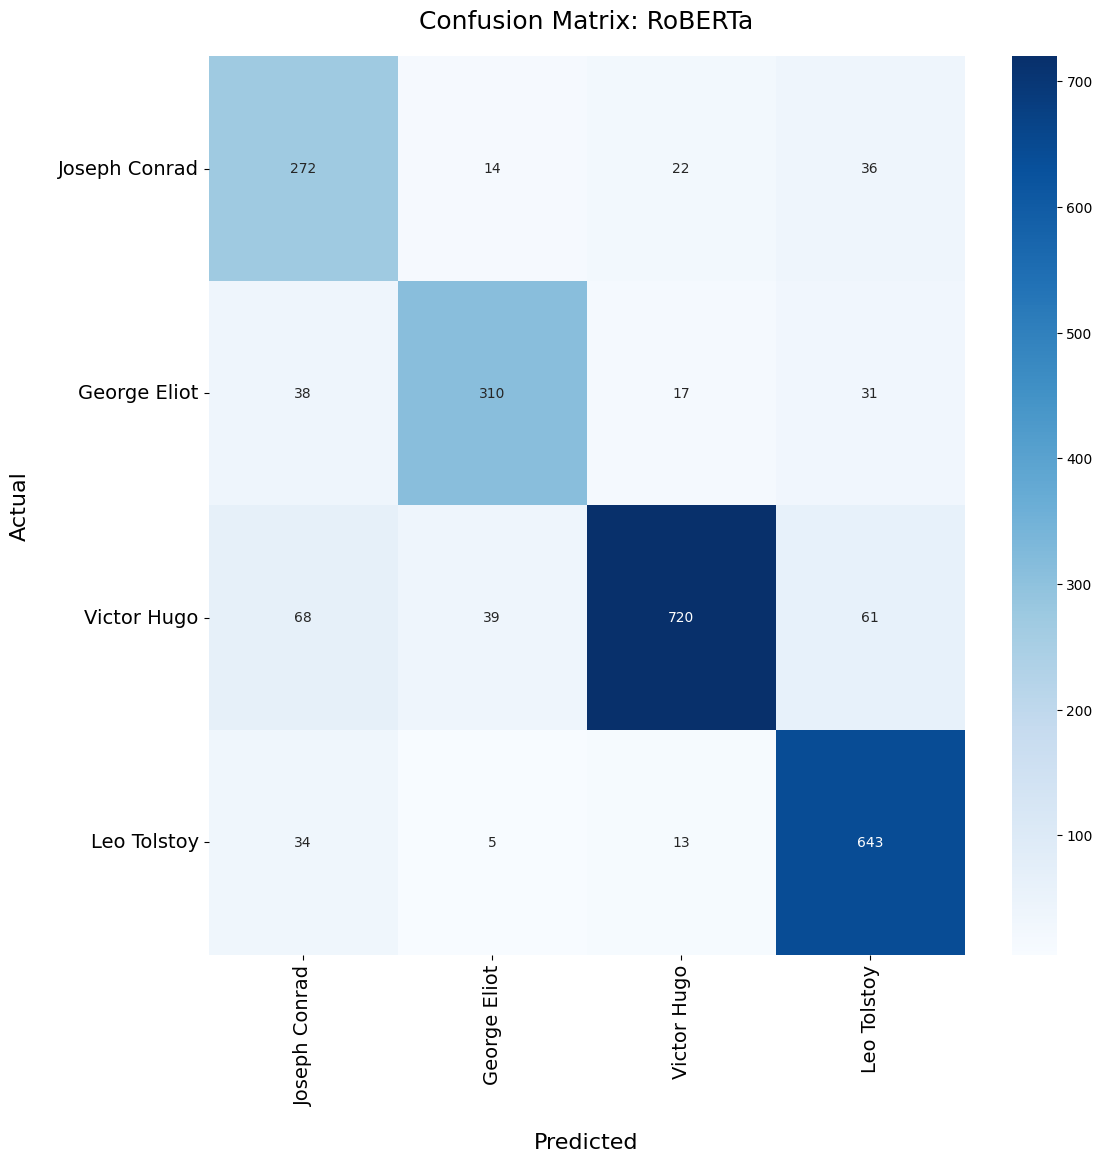

In [29]:
mcm = multilabel_confusion_matrix(test_labels, one_hot_predictions)
total_labels = mcm.shape[0]
conf_matrix = np.zeros((total_labels, total_labels), dtype=int)

for label_index in range(total_labels):
    tn, fp, fn, tp = mcm[label_index].ravel()
    conf_matrix[label_index, label_index] = tp
    for i in range(total_labels):
        if i != label_index:

            fn_other, fp_other = mcm[i, 1, 0], mcm[i, 0, 1]
            conf_matrix[label_index, i] += fn_other
            conf_matrix[i, label_index] += fp_other


label_to_author = dict(zip(authors['AuthorCode'], authors['Author']))
author_names = [label_to_author.get(i, f'Label: {i}') for i in range(total_labels)]


plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)


plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: RoBERTa', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)  


plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

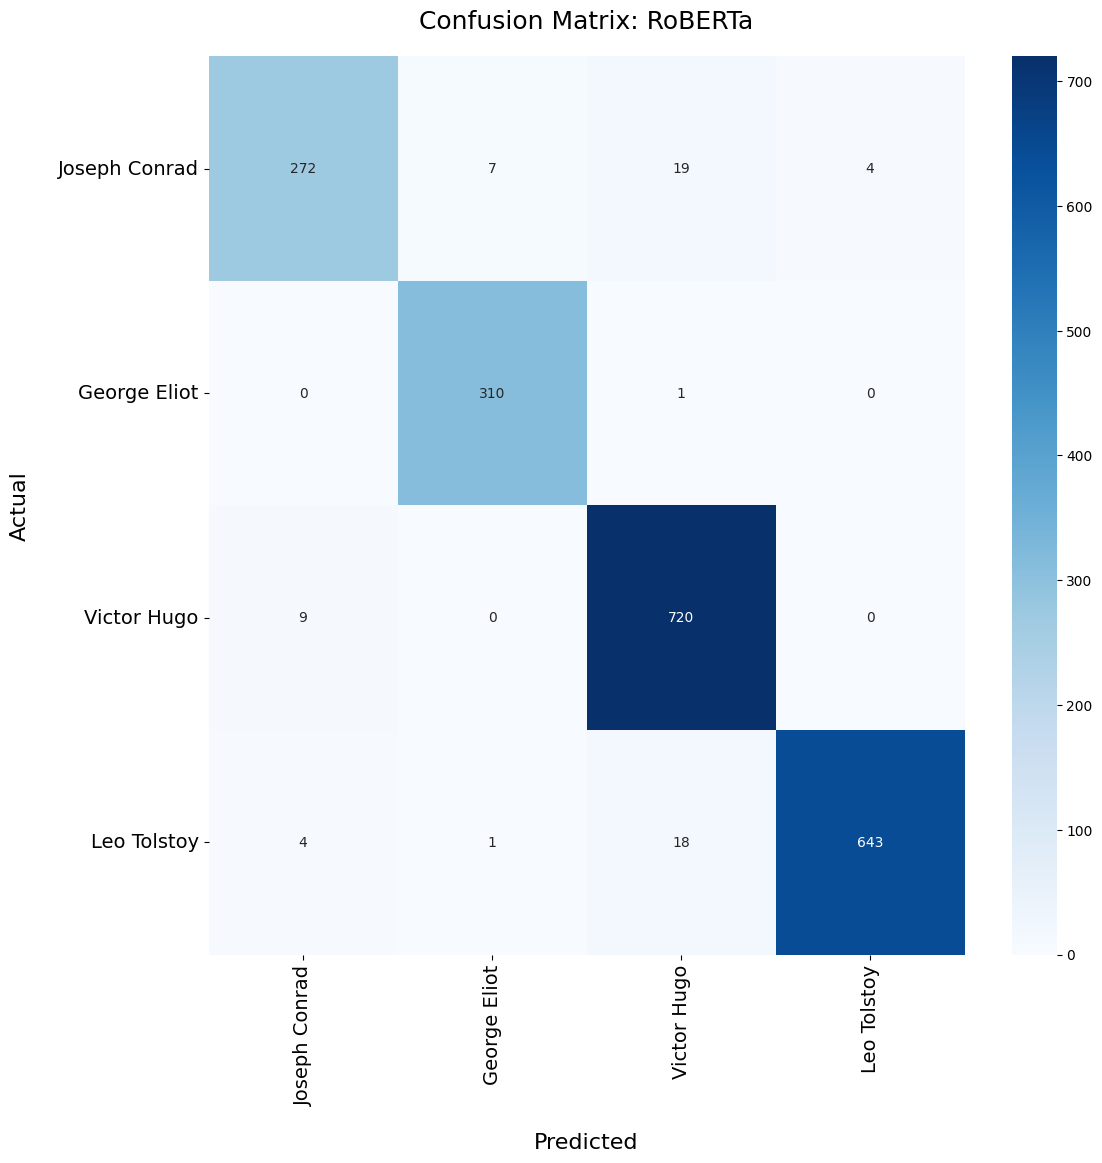

In [46]:
cm = confusion_matrix(test_labels.argmax(axis=1), one_hot_predictions.argmax(axis=1))

# Assuming authors is a dictionary mapping author codes to author names
authors = {
    0: 'Joseph Conrad',
    1: 'George Eliot',
    2: 'Victor Hugo',
    3: 'Leo Tolstoy',
}

# Extract author names in the order of their codes
author_names = [authors.get(i, f'Label: {i}') for i in range(len(authors))]

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)

plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: RoBERTa', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

In [30]:
predictions = trainer.predict(test_dataset)
print(predictions.metrics)

{'test_loss': 0.059906039386987686, 'test_accuracy': 0.9686254980079682, 'test_recall': 0.9626416510062868, 'test_precision': 0.9682286064675307, 'test_f1': 0.9650667207777289, 'test_runtime': 11.4443, 'test_samples_per_second': 175.458, 'test_steps_per_second': 7.34}


In [31]:
accuracy = predictions.metrics['test_accuracy']
recall = predictions.metrics['test_recall']
f1 = predictions.metrics['test_f1']
precision = predictions.metrics['test_precision']

In [32]:
probabilities = softmax(test_results.predictions, axis=1)


fpr, tpr, roc_auc = {}, {}, {}
n_classes = test_labels.shape[1]

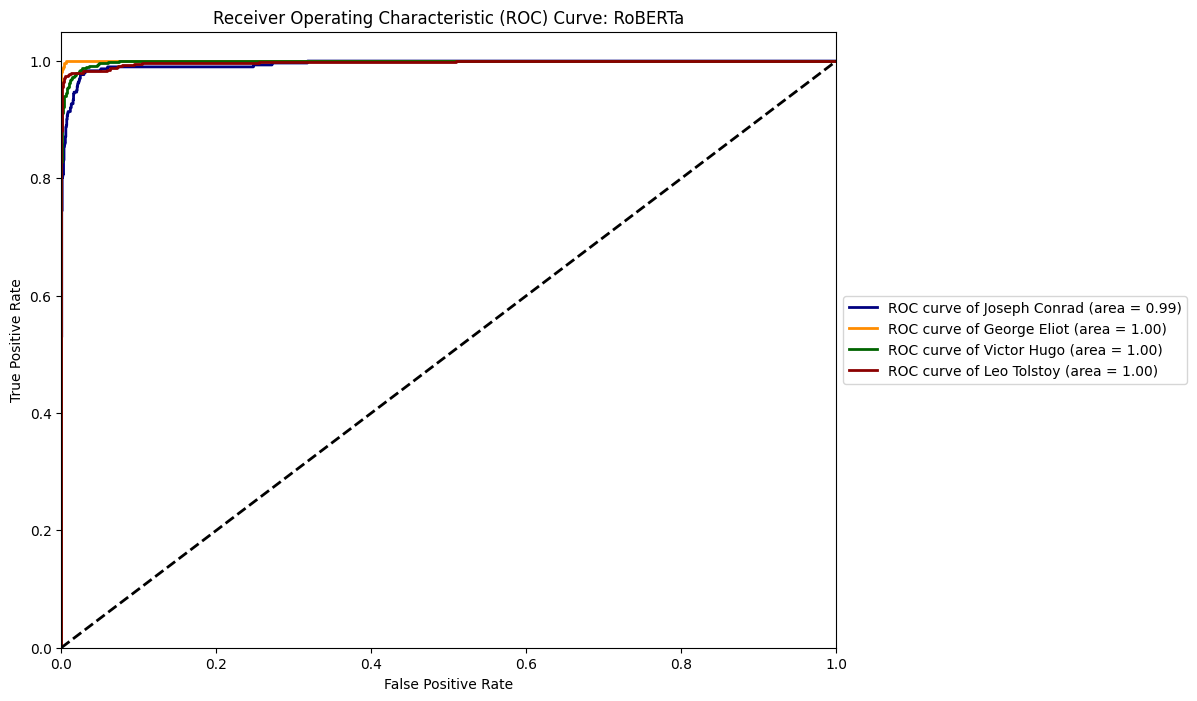

In [33]:
author_map = dict(zip(authors['AuthorCode'], authors['Author']))
from itertools import cycle

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['navy', 'darkorange', 'darkgreen', 'darkred'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {author_map.get(i, f"Class {i}")} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: RoBERTa')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f'{plots_dir}roc_4_class_RoBERTa.pdf', bbox_inches='tight')
plt.show()

In [34]:
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'F1-Score': [f1], 'Recall': [recall ]}
metrics_df = pd.DataFrame(metrics_data)

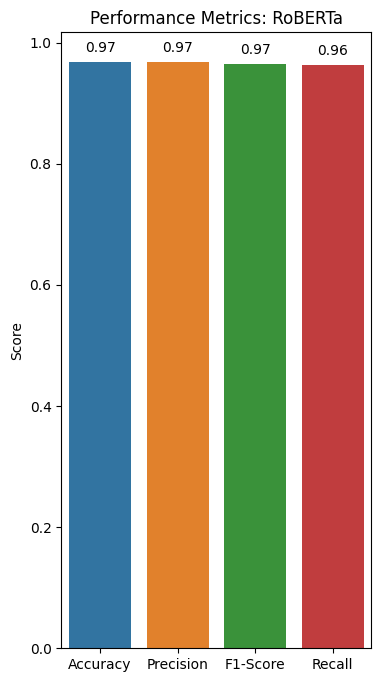

In [35]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(data=metrics_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10),  
                textcoords = 'offset points')
plt.title('Performance Metrics: RoBERTa')
plt.ylabel('Score')
plt.savefig(f'{plots_dir}performance_4_class_RoBERTa.pdf', bbox_inches='tight')
plt.show()

In [36]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Precision: ', precision)

Accuracy: 0.9686254980079682
Recall: 0.9626416510062868
F1 Score: 0.9650667207777289
Precision:  0.9682286064675307


In [37]:
steps = [50, 100, 150, 200, 250, 300]

training_loss = [0.551400, 0.268300, 0.119100, 0.102800, 0.066900, 0.054000]

validation_loss = [0.434489, 0.179766, 0.101122, 0.091275, 0.069087, 0.072133]

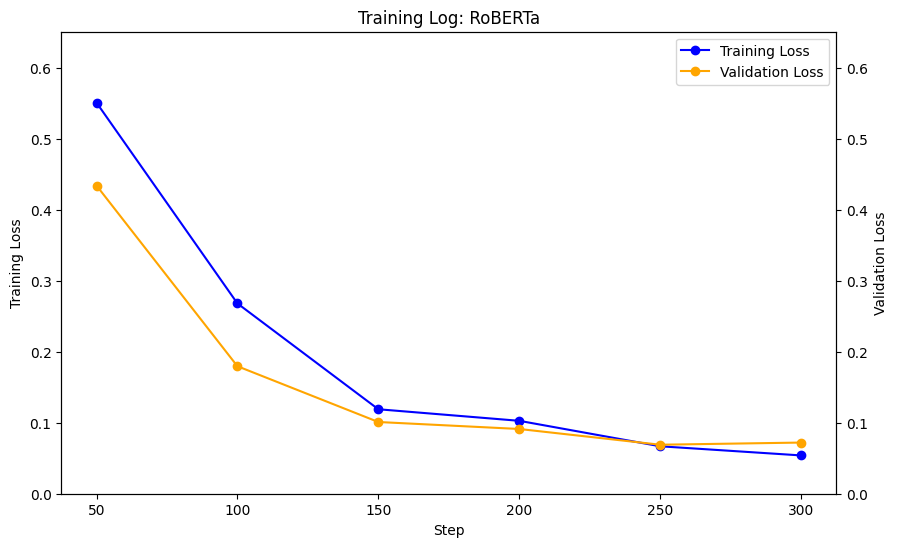

In [43]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(steps, training_loss, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Step')
ax1.set_ylabel('Training Loss')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(steps, validation_loss, label='Validation Loss', marker='o', color='orange')
ax2.set_ylabel('Validation Loss')

# Set the same scale for both y-axes, starting from 0
common_max = max(max(training_loss), max(validation_loss))
ax1.set_ylim(0, common_max + 0.1)
ax2.set_ylim(0, common_max + 0.1)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: RoBERTa')
plt.savefig(f'{plots_dir}log_rob_4.pdf', bbox_inches='tight')

plt.show()